In [56]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map, pseudo_color_map_sparse

import torch
import torch.nn as nn
from torchvision import transforms
from config import get_sensat_cfg

import plotly.graph_objects as go
import numpy as np 
from mesh_init.mesh_init_linear_solver import init_mesh_sparse
from mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from vis.vis import texture_mesh_vertices

import os
from pytorch3d.structures import Meshes
from scipy import ndimage
from torchvision import transforms
from config import get_sensat_cfg
from model.models import VoxMeshHead

from mesh_init.mesh_renderer import render_mesh_texture
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map

import meshplot as mp
import cv2
from skimage.transform import resize
import random
import trimesh

def export_obj(vertices, faces, filepath):
    with open(filepath, 'w') as f:
        # Write vertices
        for vertex in vertices:
            f.write(f"v {' '.join(map(str, vertex))}\n")
        
        # Write faces
        for face in faces:
            f.write("f")
            for vertex_index in face:
                f.write(f" {vertex_index + 1}")  # OBJ format indices are 1-based
            f.write("\n")

# Input Construction

In [71]:
files = os.listdir("../nyuv2_dataset/image")
npy_files = [file for file in files if file.endswith('.npy')]
n_imgs = len(npy_files)

for i in range(n_imgs):
    if i % 100 == 0:
        print(f"processing image {i}")
        
    n=i
    nyu_rgb = np.load(f"../nyuv2_dataset/image/{n}.npy")
    nyu_depth = np.load(f"../nyuv2_dataset/depth/{n}.npy")
    nyu_label = np.load(f"../nyuv2_dataset/label/{n}.npy")
    
    nyu_rgb = resize(nyu_rgb, (512, 512))
    nyu_depth = resize(nyu_depth, (512, 512))
    nyu_label = resize(nyu_label, (512, 512))
    
    image = np.uint8(nyu_rgb * 255)
    depth_image = nyu_depth
    
    # print(np.max(image))
    # print(np.max(depth_image))
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)
    keypoint_locations = [kp.pt for kp in keypoints]
    
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)
    
    keypoint_locations_rounded = [np.round(kp.pt).astype(int) for kp in keypoints]
    depth_values = [depth_image[loc[1], loc[0]] for loc in keypoint_locations_rounded]
    sparse_depth_image = np.zeros_like(depth_image)
    
    for depth, loc in zip(depth_values, keypoint_locations_rounded):
        if depth > 40000 or depth == 0:
            continue
        sparse_depth_image[loc[1], loc[0]] = depth
    
    additional_points = random.sample(list(np.ndindex(depth_image.shape[:2])), k=500)
    for loc in additional_points:
        depth = depth_image[loc[0], loc[1]]
        if depth > 40000 or depth == 0:
            continue
        sparse_depth_image[loc[0], loc[1]] = depth_image[loc[0], loc[1]]
    
    # # Display the sparse depth image
    # fig, axs = plt.subplots(2,2,figsize=(20,10))
    
    # axs[0,0].imshow(nyu_rgb)
    # axs[0,1].imshow(nyu_depth)
    # axs[1,0].imshow(image_with_keypoints_rgb)
    # axs[1,1].imshow(sparse_depth_image, cmap='gray')
    
    np.save(f'../nyuv2_dataset/rgb/{n}.npy', image)
    np.save(f'../nyuv2_dataset/semantic/{n}.npy', nyu_label)
    np.save(f'../nyuv2_dataset/gt_depth/{n}.npy', nyu_depth)
    np.save(f'../nyuv2_dataset/sparse_depth/{n}.npy', sparse_depth_image)

processing image 0
processing image 100
processing image 200
processing image 300
processing image 400
processing image 500
processing image 600


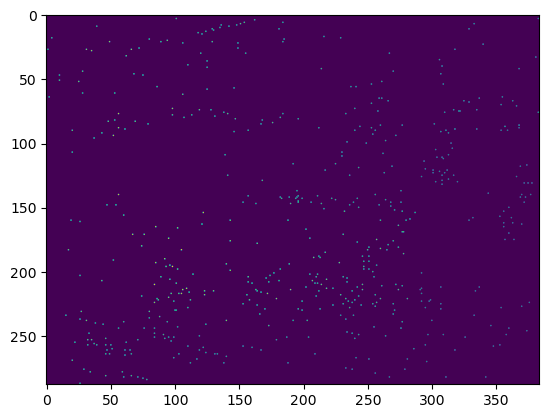

In [29]:
loaded_sparse_depth = np.load(f'../nyuv2_dataset/sparse_depth/{n}.npy')
plt.imshow(loaded_sparse_depth)

## Resampling Depths

In [100]:
files = os.listdir("../nyuv2_dataset/image")
npy_files = [file for file in files if file.endswith('.npy')]
n_imgs = len(npy_files)

for i in range(n_imgs):
    if i % 100 == 0:
        print(f"processing image {i}")
        
    n=i
    nyu_rgb = np.load(f"../nyuv2_dataset/rgb/{n}.npy")
    nyu_depth = np.load(f"../nyuv2_dataset/gt_depth/{n}.npy")
    
    image = nyu_rgb
    depth_image = nyu_depth

    # print(np.min(depth_image))
    # print(np.max(depth_image))
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)
    keypoint_locations = [kp.pt for kp in keypoints]
    
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)
    
    keypoint_locations_rounded = [np.round(kp.pt).astype(int) for kp in keypoints]
    depth_values = [depth_image[loc[1], loc[0]] for loc in keypoint_locations_rounded]
    sparse_depth_image = np.zeros_like(depth_image)
    
    for depth, loc in zip(depth_values, keypoint_locations_rounded):
        if depth > 40000 or depth == 0:
            continue
        sparse_depth_image[loc[1], loc[0]] = depth

    # print(list(np.ndindex(depth_image.shape[:2]))[:10])
    additional_points = random.sample(list(np.ndindex(depth_image.shape[:2])), k=200)
    for loc in additional_points:
        depth =  depth_image[loc[0], loc[1]]
        if depth > 40000 or depth == 0:
            continue
        sparse_depth_image[loc[0], loc[1]] = depth_image[loc[0], loc[1]]
    
    np.save(f'../nyuv2_dataset/sparse_depth/{n}.npy', sparse_depth_image)
    # plt.imshow(sparse_depth_image)

processing image 0
processing image 100
processing image 200
processing image 300
processing image 400
processing image 500
processing image 600


# Initial Test

(-0.5, 511.5, 511.5, -0.5)

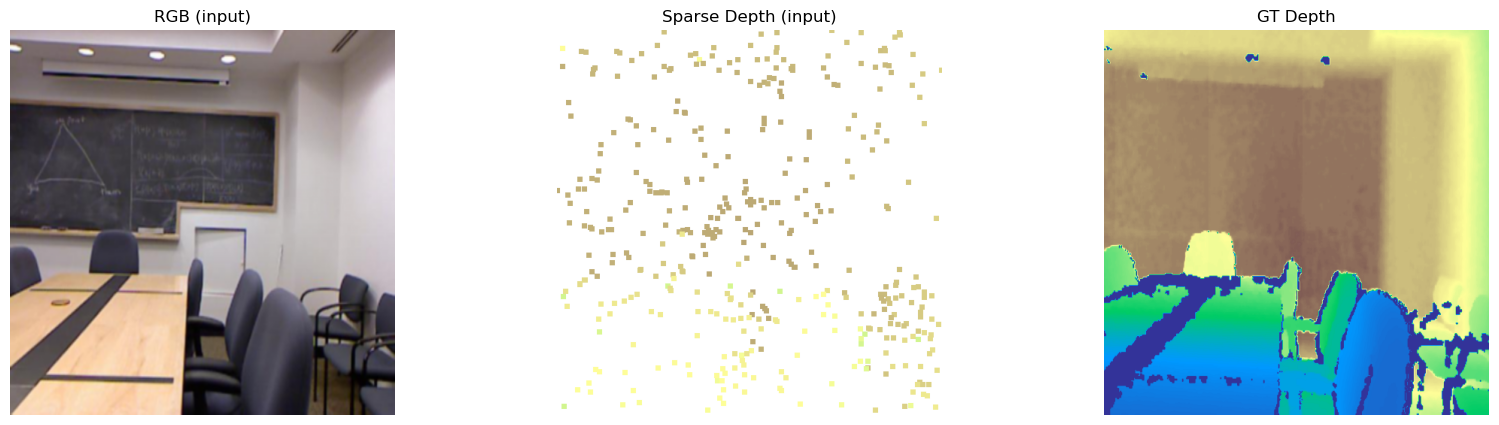

In [32]:
depth_scale = 0.5
depth_min = 50
depth_max = 600

n = 105

nyu_rgb = np.load(f"../nyuv2_dataset/rgb/{n}.npy")
nyu_sparse_depth = np.load(f"../nyuv2_dataset/sparse_depth/{n}.npy")
nyu_depth = np.load(f"../nyuv2_dataset/gt_depth/{n}.npy")
nyu_label = np.load(f"../nyuv2_dataset/semantic/{n}.npy")

rgb = nyu_rgb

sparsedepth = np.squeeze(nyu_sparse_depth)
nonzero_indices = sparsedepth != 0
nonzero_values = sparsedepth[nonzero_indices]
mapped_values = ((nonzero_values - np.min(nonzero_values)) / (np.max(nonzero_values) - np.min(nonzero_values))) * (400 - 300) + 300
sparsedepth[nonzero_indices] = mapped_values

gt_depth = np.squeeze(nyu_depth)/.01

sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
ax1.imshow(rgb)
ax1.set_title('RGB (input)')
ax1.axis('off')
ax2.imshow(sparsedepth_vis)
ax2.set_title('Sparse Depth (input)')
ax2.axis('off')
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')

# Semantic Experiments

Using cache found in /users/nxu4/.cache/torch/hub/pytorch_vision_v0.8.0
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 5, 512, 512])


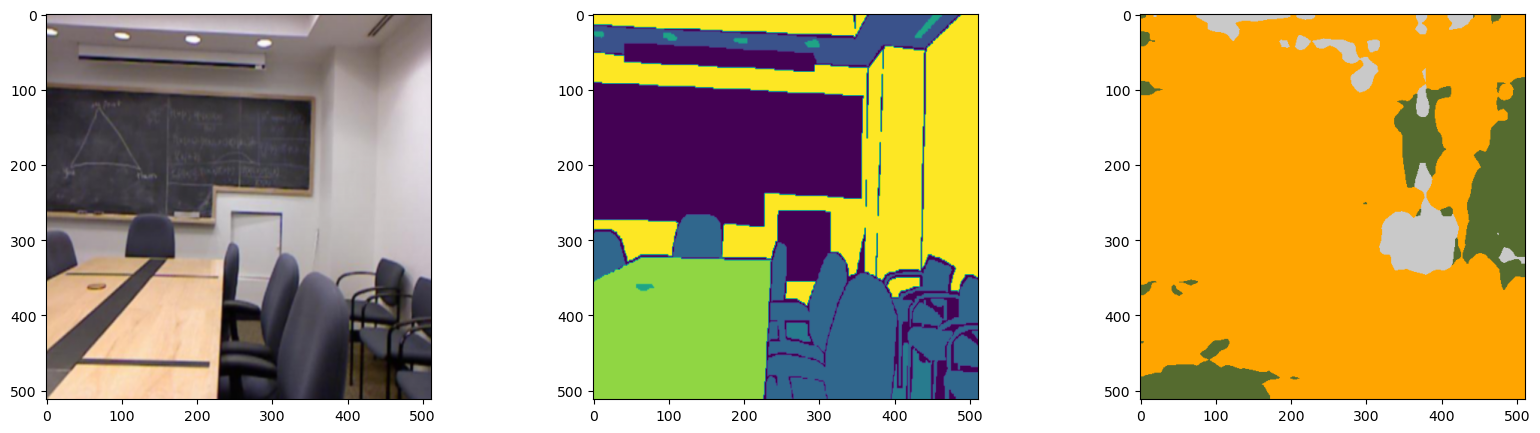

In [57]:
nyu_rgb = np.load(f"../nyuv2_dataset/rgb/{n}.npy")
nyu_label = np.load(f"../nyuv2_dataset/semantic/{n}.npy")

save_model_path = "checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

# Load a trained deeplabv3 2D semantic segmentation model
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

# The input is an RGB image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(rgb)
input_img = input_tensor.unsqueeze(0).to(device)
pred_semantic_features = model_2dseg(input_img)["out"]

# print(pred_semantic_features)
print(pred_semantic_features.shape)
pred_semantic = pred_semantic_features.detach().max(dim=1)[1].cpu().numpy()[0,::]
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
ax1.imshow(nyu_rgb)
ax2.imshow(nyu_label)
ax3.imshow(pred_semantic_vis)

# Pipeline

Using cache found in /users/nxu4/.cache/torch/hub/pytorch_vision_v0.8.0
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 5, 512, 512])


/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


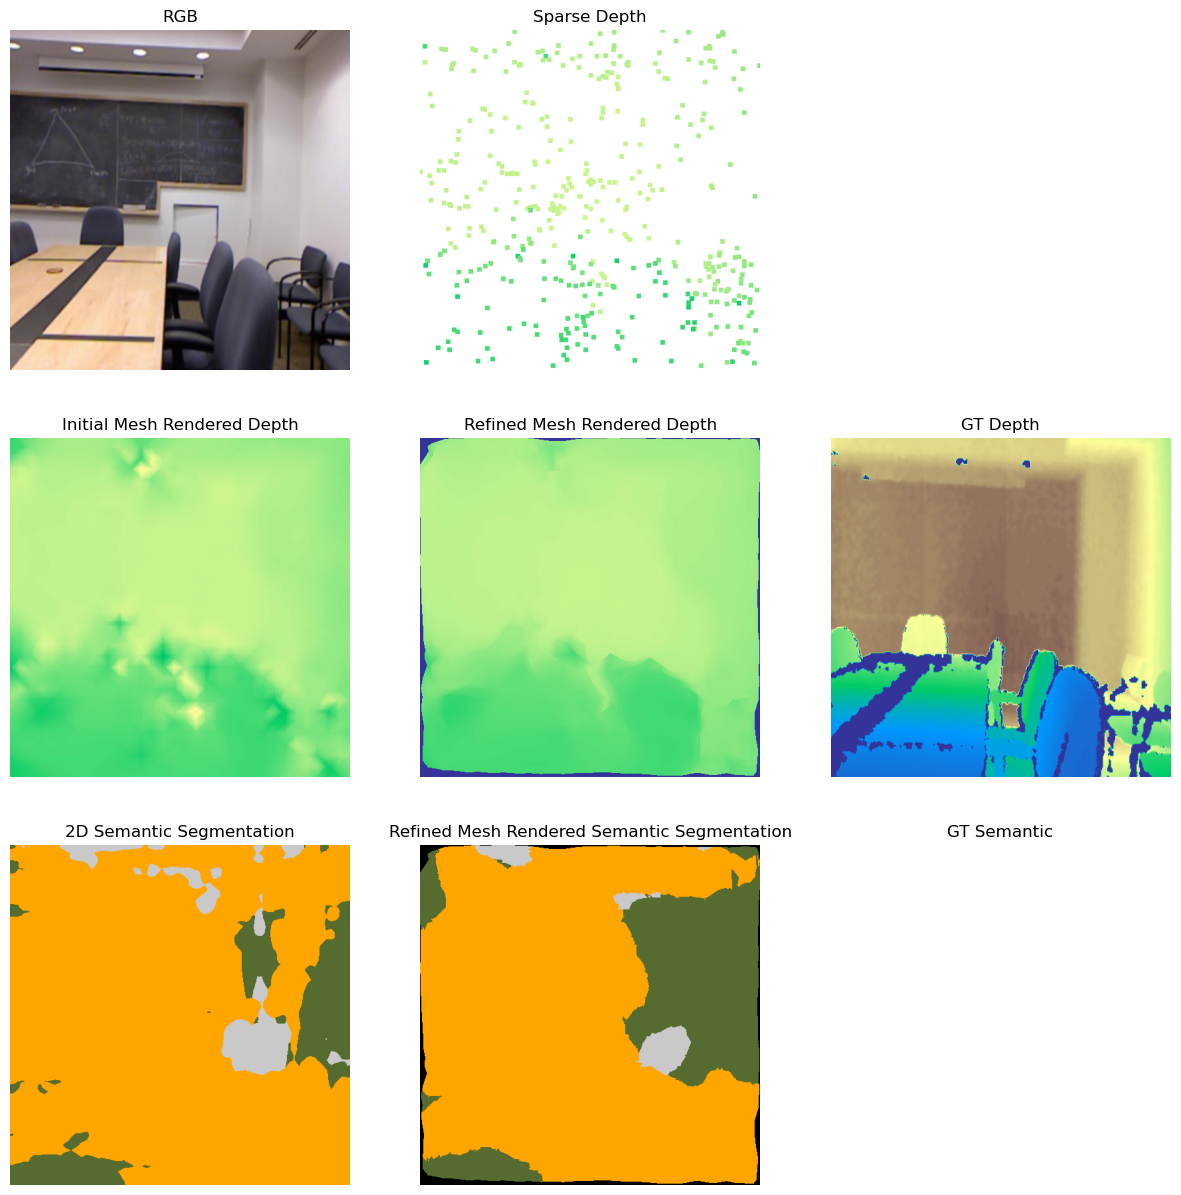

In [41]:
depth_scale = 0.5
depth_min = 50
depth_max = 600

# =================================
# LOADING IN DATA
# =================================
# rgb_file = "test_data/tv_192_rgb.png"
# sparse_depth_file = "test_data/tv_192_sparse_depth.png"
# gt_depth_file = "test_data/tv_192_depth.png"

nyu_rgb = np.load(f"../nyuv2_dataset/rgb/{n}.npy")
nyu_sparse_depth = np.load(f"../nyuv2_dataset/sparse_depth/{n}.npy")
nyu_depth = np.load(f"../nyuv2_dataset/gt_depth/{n}.npy")
nyu_label = np.load(f"../nyuv2_dataset/semantic/{n}.npy")

rgb = nyu_rgb

sparsedepth = np.squeeze(nyu_sparse_depth)/.01
nonzero_indices = sparsedepth != 0
nonzero_values = sparsedepth[nonzero_indices]
mapped_values = ((nonzero_values - np.min(nonzero_values)) / (np.max(nonzero_values) - np.min(nonzero_values))) * (300 - 200) + 200
sparsedepth[nonzero_indices] = mapped_values

gt_depth = np.squeeze(nyu_depth)/.01

sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)

# =================================
# MESH INITIALIZATION
# =================================

num_mesh_vertices = 1024
image_size = 512
focal_length = -2

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# Initialize the mesh using only the sparse depth
init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])

init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)
init_mesh_depth_vis = pseudo_color_map(init_mesh_depth,depth_min,depth_max)

init_mesh_height_color = texture_mesh_vertices(init_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])

# =================================
# SEMANTIC SEGMENTATION
# =================================

save_model_path = "checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

# Load a trained deeplabv3 2D semantic segmentation model
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

# The input is an RGB image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(rgb)
input_img = input_tensor.unsqueeze(0).to(device)
pred_semantic_features = model_2dseg(input_img)["out"]

# print(pred_semantic_features)
print(pred_semantic_features.shape)
pred_semantic = pred_semantic_features.detach().max(dim=1)[1].cpu().numpy()[0,::]
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)

# =================================
# MESH REFINEMENT
# =================================

save_model_path = "checkpoints/Sem_Dice/model_best_depth.tar"
device = torch.device("cuda:0")

# Load a trained 2D-3D model for mesh refinement
cfg = get_sensat_cfg()
cfg.merge_from_file(os.path.join(save_model_path,"..","Sensat_basic.yaml"))
model = VoxMeshHead(cfg)
checkpoint = torch.load(save_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# Combine the 2D inputs, including the RGB, the initial mesh rendered depth and the sparse depth EDT.
rgb_tensor = transforms.ToTensor()(rgb).unsqueeze(0).to(device)
init_mesh_depth_tensor = transforms.ToTensor()(init_mesh_depth/depth_scale).unsqueeze(0).to(device)
sparsedepth_mask = (sparsedepth<=0)*1
depth_edt = ndimage.distance_transform_edt(sparsedepth_mask)
depth_edt_tensor = transforms.ToTensor()(depth_edt).unsqueeze(0).to(device)
input_img = torch.cat((rgb_tensor, init_mesh_depth_tensor, depth_edt_tensor), dim=1).to(torch.float)

# Normalized the mesh
init_mesh_scale = torch.mean(init_mesh_vertices_tensor[:,2])
init_mesh_vertices_norm_tensor = init_mesh_vertices_tensor / init_mesh_scale
init_mesh = Meshes(verts=[init_mesh_vertices_norm_tensor], faces=[init_mesh_faces_tensor])

# The model takes in the concatenated 2D inputs, the initial mesh and the 2D semantic segmentation
refine_mesh = model(input_img, init_mesh, pred_semantic_features)
refine_mesh = refine_mesh[1].scale_verts(init_mesh_scale.unsqueeze(0).to(device))

refine_mesh_semantic, refine_mesh_depth = render_mesh_texture(refine_mesh,image_size=image_size,focal_length=focal_length,device=device)
refine_mesh_semantic_vis = convert_class_to_rgb_sensat_simplified(refine_mesh_semantic)
refine_mesh_depth_vis = pseudo_color_map(refine_mesh_depth,depth_min,depth_max)

refine_mesh_vertices, refine_mesh_faces = refine_mesh.get_mesh_verts_faces(0)
refine_mesh_vertices = refine_mesh_vertices.detach().cpu().numpy()
refine_mesh_faces = refine_mesh_faces.detach().cpu().numpy()
refine_mesh_height_color = texture_mesh_vertices(refine_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])

fig, ((ax11,ax12,ax13),(ax21,ax22,ax23),(ax31,ax32,ax33)) = plt.subplots(3,3,figsize=(15,15))

ax11.imshow(rgb)
ax11.set_title('RGB')
ax11.axis('off')
ax12.imshow(sparsedepth_vis)
ax12.set_title('Sparse Depth')
ax12.axis('off')
ax13.axis('off')

ax21.imshow(init_mesh_depth_vis)
ax21.set_title('Initial Mesh Rendered Depth')
ax21.axis('off')
ax22.imshow(refine_mesh_depth_vis)
ax22.set_title('Refined Mesh Rendered Depth')
ax22.axis('off')
ax23.imshow(gt_depth_vis)
ax23.set_title('GT Depth')
ax23.axis('off')

ax31.imshow(pred_semantic_vis)
ax31.set_title('2D Semantic Segmentation')
ax31.axis('off')
ax32.imshow(refine_mesh_semantic_vis)
ax32.set_title('Refined Mesh Rendered Semantic Segmentation')
ax32.axis('off')
# ax33.imshow(gt_sem_vis)
ax33.set_title('GT Semantic')
ax33.axis('off')

plt.show()

In [34]:
mp.plot(refine_mesh_vertices@rotate_matrix, refine_mesh_faces, refine_mesh_height_color)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.833717…

In [ ]:
# APPLY A MESH DENOISING STEP
export_obj(refine_mesh_vertices, refine_mesh_faces, "../output/out.obj")
mesh = trimesh.load_mesh("../output/out.obj")
smoothed_mesh = trimesh.smoothing.filter_laplacian(mesh)
smoothed_mesh.export("../output/denoised.obj")

original_max = np.max(nonzero_values)
original_min = np.min(nonzero_values)

new_vertices = smoothed_mesh.vertices.copy()
z_vals = new_vertices[:,2]
z_vals_scaled = ((z_vals - np.min(z_vals)) / (np.max(z_vals) - np.min(z_vals))) * (original_max - original_min) + original_min
new_vertices[:,2] = z_vals_scaled
export_obj(new_vertices, refine_mesh_faces, "../output/denoised-mapped.obj")

In [55]:
mp.plot(new_vertices@rotate_matrix, refine_mesh_faces, refine_mesh_height_color)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.474754…